In [4]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import librosa
import soundfile as sf
import scipy
import os # os module: way of interacting with the operating system, python module
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
# iPython magic function (predefined function) that sets up matplotlib to work interactively
%matplotlib inline 

### Load style and content

In [5]:
np.random.seed(60) # for consistency when generating random numbers

In [6]:
CONTENT_FILENAME = "Cristina Vane - So Easy.mp3"
STYLE_FILENAME = "Louis Cressy Band - Good Time.mp3"

In [7]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [8]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048                       # length of the windowed signal (how many samples)
def read_audio_spectum(filename):
    x, fs = librosa.load(filename) # audio file -> floating point time series. outputs audio time series & sampling rate
    S = librosa.stft(x, N_FFT)     # short time fourier transform. results in time-frequency graph
    p = np.angle(S)                # get angles of each complex value in the array resulting from stft. gets phase
    # np.abs: magnitude in the format [..., frequency bin, time]
    S = np.log1p(np.abs(S[:,:430])) # natural log + 1 of input. for input, take all rows, only some of the columns. log to make info more visually revealing
    return S, fs                    # S is a matrix of stft coefficients

In [9]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]   
N_CHANNELS = a_content.shape[0] 
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

C:\Users\lucy\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
C:\Users\lucy\AppData\Local\Temp/ipykernel_21904/2556808375.py:6: FutureWarning: Pass n_fft=2048 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.stft(x, N_FFT)     # short time fourier transform. results in time-frequency graph


### Visualize spectrograms for content and style tracks

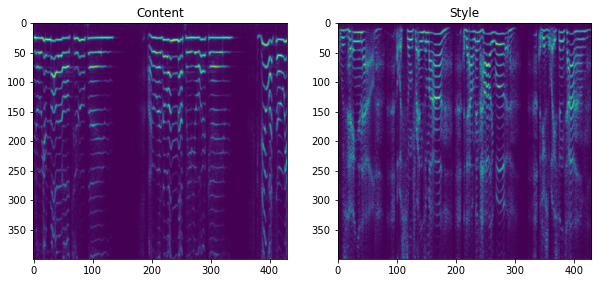

In [10]:
# time (ms) vs. frequency (Hz)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [11]:
# LUCY'S notes on Tensorflow & Convolutional :
# tensor: generalization of matrix on n-dimensional space. container used with neural network data (usually greater than
# or equal to 3 dimensions). have a data type and shape
# np arrays and tensors have the same underlying representation if possible
# graphs and sessions manage tensors & output. graphs rep function computations, dataflow between tf operations & tensors
# CNNs: takes input as 2D array and operates directly on the picture (i.e. in image processing). mostly used for feature
# extraction. implements multiple local filters.
# convolutional layer performs a convolution: dot product of weights with an input (in this case, 2D. filter/kernel: 2D
# array of weights). results in a 2D output, feature map
# values in the filter are learned during training
# pick features to minimize loss
# convolutional layer learns 4096 features
# multiple channels: i.e. for an image, might have three channels for rgb, filter's depth (# channels) must match as well
# can stack multiple convolutional layers to learn more and more abstract features
# 2D convolutional layer: 4 dimensions. 1st - # of samples. 2nd - # of rows. 3rd - # of columns. 4th - # of channels
# filter should be: columns, rows, channels shape
# output: batches, rows, columns, channels (batch aka sample, or batch: a group of inputs and outputs)

In [12]:
N_FILTERS = 4200 # HYPERPARAMETER TO CHANGE ? 4096 filters before

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:]) # shape: 1, 1, 430, 1025
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
# randomly set the filter parameters - an array of filters where each filter is columns, rows, channels
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std # parameters are the dimensions. 1, 11, 1025, 4096. 
# another POSSIBLE HYPERPARAMETER: how to determine filter size? i.e. 1x11
    
g = tf.Graph()
# put a bunch of operations into the graph, "with" keyword means all ops in the next block will be in the graph
# Session: class for running tf operations
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1], # stride of the sliding window
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv) # relu activation function: turn output values into a threshold

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [15]:
# LUCY'S NOTES:
# # https://www.tensorflow.org/guide/basic_training_loops  
# machine learning problem flow:
# find training data, define model, define loss function, run through training data & calculate loss
# calculate gradients for that loss and optimize the model, evaluate

In [16]:
# brief record of experiments to improve loss value to around 500:
# GradientDescentOptimizer:
# lr = .001, 15 iter -> loss = 150k
# lr = .01, 15 iter -> loss = 150k
# lr = .1, 15 iter -> loss = 5427
# lr = .08, 50 iter -> loss = 1441
# lr = .06, 80 iter -> loss = 1374
# lr = .1, 80 iter -> loss = 1197
# lr = .3, 80 iter -> loss = TOO BIG
# lr = .15, 80 iter -> loss = TOO BIG
# ProximalGradientDescentOptimizer:
# lr = .1, 80 iter -> loss = 1179
# lr = .08, 15 iter -> loss = 12290

In [21]:
# GOAL: train the model to get the optimal filter values to extract features from the audio
from sys import stderr

ALPHA= .0001
learning_rate= .1   # scales the gradient descent equation. too small - too slow. too big - might skip solution
iterations = 100    # number of training loops

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
# similar to placeholder from above, but variable
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
       
    net = tf.nn.relu(conv)
    print(net.get_shape())

    # loss: difference between expected output and actual output. loss - to help network adjust filter weights
    # in this case - content_features is the ground truth
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    # map function: returns an iterator. map(function, iter). apply function to each item in iter
    _, height, width, number = map(lambda i: i, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss
    
    # Optimization
    print('Started optimization.')

    opt = tf.train.GradientDescentOptimizer(learning_rate)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(iterations):
            opt_op = opt.minimize(loss, var_list=[x])
            opt_op.run(session=sess)
            print('Loss ', i, ': ', loss.eval())
    
        result = x.eval()
    
    # other options for optimizers...
    # scipy.optimize.minimize() with L-BFGS-B option, maxiter=300
    # tfp.optimizer.bfgs_minimize (need to do some work with the tensor shapes & convert back and forth)
    # other tf optimizers?

(1, 1, 420, 4200)
Started optimization.
Loss  0 :  55032.188
Loss  1 :  55032.086
Loss  2 :  55031.895
Loss  3 :  55031.535
Loss  4 :  55030.82
Loss  5 :  55029.332
Loss  6 :  55026.094
Loss  7 :  55018.89
Loss  8 :  55002.543
Loss  9 :  54964.934
Loss  10 :  54877.723
Loss  11 :  54674.797
Loss  12 :  54203.46
Loss  13 :  53120.91
Loss  14 :  50709.312
Loss  15 :  45719.5
Loss  16 :  36987.785
Loss  17 :  26182.63
Loss  18 :  18452.926
Loss  19 :  14274.39
Loss  20 :  11491.305
Loss  21 :  9477.261
Loss  22 :  7948.542
Loss  23 :  6750.0537
Loss  24 :  5788.0083
Loss  25 :  5001.483
Loss  26 :  4351.279
Loss  27 :  3809.6267
Loss  28 :  3354.6453
Loss  29 :  2972.1382
Loss  30 :  2650.1604
Loss  31 :  2378.7935
Loss  32 :  2148.5862
Loss  33 :  1953.0924
Loss  34 :  1786.3179
Loss  35 :  1643.505
Loss  36 :  1520.817
Loss  37 :  1415.2312
Loss  38 :  1323.9534
Loss  39 :  1244.8275
Loss  40 :  1175.9392
Loss  41 :  1115.667
Loss  42 :  1062.8127
Loss  43 :  1016.2853
Loss  44 :  975.1

### Invert spectrogram and save the result

In [22]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'out.wav'
#librosa.output.write_wav(OUTPUT_FILENAME, x, fs) original - deprecated
sf.write(file=OUTPUT_FILENAME, data=x, samplerate=fs)

C:\Users\lucy\AppData\Local\Temp/ipykernel_21904/1664294035.py:9: FutureWarning: Pass n_fft=2048 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  p = np.angle(librosa.stft(x, N_FFT))


In [23]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

out.wav


### Visualize spectrograms

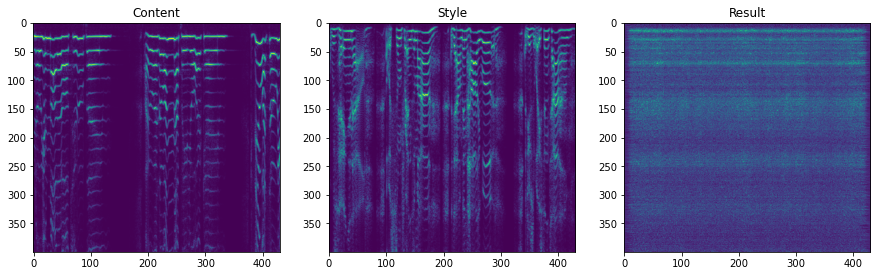

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()